In [1]:
# Объединение данных JPG & TIF (2017-07-03)

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skm
from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
import xgboost as xgb

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
sys.path.append('../Python')
from helper import paths_input, formImExt, formImHist
from estimate import confusion_matrix, getConfusion, getRocAUC, getProb01, getProbX01, getTh, estimateResult

In [7]:
binsData = 64

trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
trWork, teWork = '../Work/Train', '../Work/Test'
print (trWork, teWork)
print (trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG)

../Work/Train ../Work/Test
../Data/train_v2.csv ../Data/train-tif-v2 ../Data/train-jpg ../Data/test-tif-v2 ../Data/test-jpg-v2


In [8]:
binsDataTIF = 64
binsDataJPG = 64

In [9]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [10]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [11]:
# Add features (0 or 1) for every label as dataframe field 
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
#labels_df.head()

In [12]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [13]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
#labelList[:6,:]
#labels_df.head()

In [14]:
# Данные для объединения от jpg
##binsDataJPG2 = 64
trX_TIF  = np.load('../Data-XGB/Datas/train-'+str(10000+binsDataTIF)+'.tif'+'-XX.npy')
trX_JPG  = np.load('../Data-XGB/Datas/train-'+str(10000+binsDataJPG)+'.jpg'+'-XX.npy')
##trX_JPG2 = np.load('../Work/train-data-XX'+str(binsDataJPG2)+'.jpg'+'.npy')
trY      = np.load('../Data-XGB/Datas/train-'+str(10000+binsDataJPG)+'.jpg'+'-YY.npy')
trX_TIF.shape, trX_JPG.shape

((40479, 512), (40479, 192))

In [15]:
## Обрезка видимой части и использование только n, ndvi, ndwi
##trX_TIF = trX_TIF[:,288:]

In [16]:
##trX_TIF.shape, 290/3

In [17]:
##trXX = np.hstack([trX_JPG,trX_JPG2,trX_TIF])
trXX = np.hstack([trX_JPG,trX_TIF])
trX  = trXX
print (trX.shape,trX_TIF.shape,trX_JPG.shape,trY.shape)
##del trXX,trX_JPG,trX_TIF,trX_JPG2
del trXX,trX_JPG,trX_TIF

(40479, 704) (40479, 512) (40479, 192) (40479, 17)


In [18]:
# Строим основные массивы
dtrain = xgb.DMatrix(trX,label=trY[:,0])

In [19]:
# Построение списка bst - моделей
def getListBST (param, trX, trY, nfold=3, early_stop=20) :
    dtrain = xgb.DMatrix(trX,label=trY[:,0])
    results, bstList = [], []
    for i in range(trY.shape[1]) :
        print ('Working: {}'.format(i))
        dtrain.set_label(trY[:,i])
        history = xgb.cv(param, dtrain, metrics=['auc'], 
                         verbose_eval=30, num_boost_round=5000, nfold=nfold, 
                         early_stopping_rounds=early_stop)
        results.append(history)
        rvalidCV, watchlistCV = {}, [(dtrain,'train')]
        bst = xgb.train(param, dtrain, history['test-auc-mean'].argmax()+1, watchlistCV) 
        bstList.append(bst)
    return(bstList)

# Построение решения по dmatrix и bst списку
def buildPredict (dData, bstList) :
    trYP = []
    for bstI in bstList :
        trYP1 = bstI.predict(dData); trYP.append(trYP1)
    trYP = np.array(trYP).T
    #type(trYP),trYP.shape
    return(trYP)

# Построение решения по np.array (DataFrame?) и bst списку
def buildPredictX (Data, bstList) :
    dData = xgb.DMatrix(Data);
    return (buildPredict(dData,bstList))

In [20]:
param = {
         'objective':'reg:logistic', 
         #'num_class':17,
         #'eta':0.05, 
         #'max_depth':9, 'subsample':0.8, 'colsample_bytree':0.8, 
         #'metrics':'rmse'
         'eval_metric':['auc','rmse']
        }
param['silent']=True

In [21]:
# Считаем
print(datetime.datetime.now(),'Begin')
bstList = getListBST(param,trX,trY)
print(datetime.datetime.now(),'End')

2017-07-09 03:08:20.443352 Begin
Working: 0
[0]	train-auc:0.941797+0.00073431	test-auc:0.927294+0.00843109
[30]	train-auc:0.99269+0.00065471	test-auc:0.962943+0.00164549
[0]	train-auc:0.939863	train-rmse:0.377918
[1]	train-auc:0.957874	train-rmse:0.299136
[2]	train-auc:0.963628	train-rmse:0.24844
[3]	train-auc:0.965077	train-rmse:0.216401
[4]	train-auc:0.968501	train-rmse:0.196323
[5]	train-auc:0.970801	train-rmse:0.184097
[6]	train-auc:0.973302	train-rmse:0.176096
[7]	train-auc:0.974648	train-rmse:0.171351
[8]	train-auc:0.975382	train-rmse:0.168493
[9]	train-auc:0.977162	train-rmse:0.164469
[10]	train-auc:0.977685	train-rmse:0.162811
[11]	train-auc:0.978608	train-rmse:0.16142
[12]	train-auc:0.980202	train-rmse:0.159748
[13]	train-auc:0.980868	train-rmse:0.158361
[14]	train-auc:0.981837	train-rmse:0.157322
[15]	train-auc:0.982768	train-rmse:0.155848
[16]	train-auc:0.983184	train-rmse:0.155049
[17]	train-auc:0.983706	train-rmse:0.154095
[18]	train-auc:0.984232	train-rmse:0.15311
[19]	tr

In [22]:
# Шаблоны имен файллов для сохранения моделей xgb
fModel1 = '../Data-XGB/Models/model-'
fModel2 = '-jpg'+str(binsDataJPG)+'-tif'+str(binsDataTIF)+'.xgb'

In [23]:
# save xgb models into files
for i in range(len(bstList)) :
    ##bstList[i].save_model(fModel1+str(100+i)+'-JPG2'+fModel2)
    bstList[i].save_model(fModel1+str(100+i)+fModel2)

In [615]:
# load xgb models into files
bstNull = xgb.train(param,dtrain,0)
bstList0= []
for i in range(trY.shape[1]) :
    bstList0.append(bstNull.copy())
    bstList0[-1].load_model(fModel1+str(100+i)+fModel2)
bstList = bstList0
del bstList0
len(bstList)

17

In [24]:
#
#  Построение решения для train массива на основе уровней прохождения (эффект почему-то дают)
#    Построенное решение 01 полное с учетом погодных критериев [0,3,9,10]
#        и особенности критерия cloudy (посмотреть и сменить можно в getProbX01)
#        Построение критериев прохождения в getTh
#

# train
trYP    = buildPredict(dtrain,bstList)

# Уровни прохождения & решение
trPPP,_ = getTh (trY,trYP)
trY01    = getProbX01(trYP,trPPP)
#trYP[0],trY01,trPPP

In [25]:
trYP[0],trY01[0],trY[0] #trPPP

(array([  7.40683734e-01,   9.98939216e-01,   6.13526208e-03,
          4.60757203e-02,   1.39357112e-02,   1.46577077e-03,
          2.27092579e-03,   4.15656157e-03,   9.02566317e-05,
          8.49509888e-05,   9.99427066e-05,   2.29033158e-05,
          2.66846153e-03,   2.02235447e-06,   2.23565308e-04,
          7.31454871e-04,   1.74619738e-04], dtype=float32),
 array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [26]:
temp = estimateResult(trY,trY01,printOK=True)

0 acc=0.987252649522 roc=0.927235082429 not=516 yes=2314 no=37649 true=39963 all-1-0=(0.8580-0.9965)
1 acc=0.995429728995 roc=0.988064029914 not=185 yes=37389 no=2905 true=40294 all-1-0=(0.9967-0.9794)
2 acc=0.980137849255 roc=0.97617610685 not=804 yes=11897 no=27778 true=39675 all-1-0=(0.9661-0.9863)
3 acc=0.987450282863 roc=0.98209825483 not=508 yes=28298 no=11673 true=39971 all-1-0=(0.9953-0.9689)
4 acc=0.935892685096 roc=0.865595969718 not=2595 yes=5593 no=32291 true=37884 all-1-0=(0.7547-0.9765)
5 acc=0.964722448677 roc=0.877260893899 not=1428 yes=2820 no=36231 true=39051 all-1-0=(0.7705-0.9840)
6 acc=0.970280886386 roc=0.953805757734 not=1203 yes=7477 no=31799 true=39276 all-1-0=(0.9264-0.9812)
7 acc=0.935200968403 roc=0.810035182569 not=2623 yes=2907 no=34949 true=37856 all-1-0=(0.6493-0.9708)
8 acc=0.999827070827 roc=0.992773301744 not=7 yes=206 no=40266 true=40472 all-1-0=(0.9856-0.9999)
9 acc=0.999505916648 roc=0.99860789177 not=20 yes=2084 no=38375 true=40459 all-1-0=(0.9976

In [34]:
temp = estimateResult(trY,trY01,printOK=True)

0 acc=0.985078682774 roc=0.914535963562 not=604 yes=2247 no=37628 true=39875 all-1-0=(0.8331-0.9959)
1 acc=0.98861137874 roc=0.965755485727 not=461 yes=37233 no=2785 true=40018 all-1-0=(0.9925-0.9390)
2 acc=0.968724523827 roc=0.964615530127 not=1266 yes=11750 no=27463 true=39213 all-1-0=(0.9541-0.9751)
3 acc=0.983497616048 roc=0.976247318068 not=668 yes=28265 no=11546 true=39811 all-1-0=(0.9942-0.9583)
4 acc=0.945280268781 roc=0.884376088937 not=2215 yes=5842 no=32422 true=38264 all-1-0=(0.7883-0.9805)
5 acc=0.970429111391 roc=0.898729640657 not=1197 yes=2969 no=36313 true=39282 all-1-0=(0.8112-0.9863)
6 acc=0.932508214136 roc=0.882996172102 not=2732 yes=6462 no=31285 true=37747 all-1-0=(0.8006-0.9653)
7 acc=0.958496998444 roc=0.888653531608 not=1680 yes=3577 no=35222 true=38799 all-1-0=(0.7990-0.9783)
8 acc=0.999925887497 roc=0.992822966507 not=3 yes=206 no=40270 true=40476 all-1-0=(0.9856-1.0000)
9 acc=0.997875441587 roc=0.992542823764 not=86 yes=2061 no=38332 true=40393 all-1-0=(0.9

In [27]:
# Построение значимости полей для разных признаков (importance)
bstga   = np.zeros((trX.shape[1],trY.shape[1]))
for i in range(len(bstList)) :
    bstgfs = bstList[i].get_fscore()
    bstgfs = [(int(n.split('f')[1]),bstgfs[n]) for n in bstgfs.keys()]
    bstga1 = np.array(bstgfs)
    bstga[bstga1[:,0],i] = bstga1[:,1]


if False :
    #bstgfs.sort(key=lambda x: -x[1])
    #bstgfs[:20]
    plt.hist([nn for n,nn in bstgfs],bins=11); plt.show()
    bst_gfs_main = [(n,nn) for n,nn in bstgfs if nn>=20]
    bst_gfs_main.sort(key=lambda x: x[0])
    bst_gfs_main
    bstga[:,6]

In [28]:
temp[0]

array([  0.00000000e+00,   4.04790000e+04,   9.87252650e-01,
         9.27235082e-01,   2.69700000e+03,   3.77820000e+04,
         2.31400000e+03,   3.76490000e+04,   5.16000000e+02])

[4, 5, 6, 7]


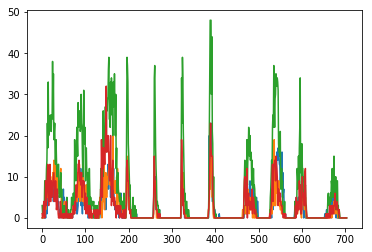

['water', 'habitation', 'road', 'cultivation']

In [29]:
xx = [int(x[0]) for x in temp if x[8]>=1000] # плохие lost >=1000
print(xx)
plt.plot(bstga[:,xx]); 
#plt.legenda([labels[x] for x in xx])
plt.show();
[labels[x] for x in xx]


[0, 1, 2, 3, 12]


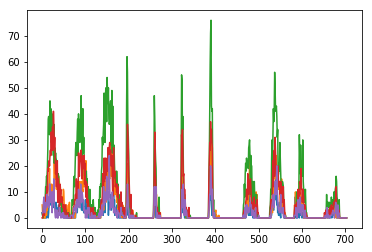

['haze', 'primary', 'agriculture', 'clear', 'bare_ground']

In [30]:
xx = [int(x[0]) for x in temp if x[8]<1000 and x[8]>100] # среднии lost <=1000
print(xx)

plt.plot(bstga[:,xx]); 
#plt.legenda([labels[x] for x in xx])
plt.show();
[labels[x] for x in xx]


[8, 9, 10, 11, 13, 14, 15, 16]


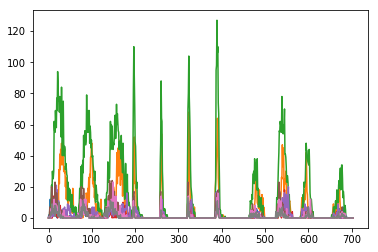

['slash_burn',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'artisinal_mine',
 'blooming',
 'selective_logging',
 'blow_down']

In [31]:
xx = [int(x[0]) for x in temp if x[8]<=100] # хорошие lost <=100
print(xx)
plt.plot(bstga[:,xx]); plt.show();
[labels[x] for x in xx]

In [32]:
del trX

In [33]:
# Данные для объединения от jpg
##trOX_JPG1 = np.load('../Work/test-data-XX'+str(binsDataJPG)+'.jpg'+'.npy')
##trOX_JPG2 = np.load('../Work/test-data-XX'+str(binsDataJPG2)+'.jpg'+'.npy')
#trOY_JPG1 = np.load('../Work/test-data-YY'+str(binsDataJPG)+'.jpg'+'.npy')
#trOY_JPG2 = np.load('../Work/test-data-YY'+str(binsDataJPG2)+'.jpg'+'.npy')
trOX_JPG  = np.load('../Data-XGB/Datas/test-'+str(10000+binsDataJPG)+'.jpg'+'-XX.npy')
trOX_TIF  = np.load('../Data-XGB/Datas/test-'+str(10000+binsDataTIF)+'.tif'+'-XX.npy')
trOY_TIF  = np.load('../Data-XGB/Datas/test-'+str(10000+binsDataTIF)+'.tif'+'-YY.npy')
trOY_JPG  = np.load('../Data-XGB/Datas/test-'+str(10000+binsDataJPG)+'.jpg'+'-YY.npy')

In [34]:
#trOX_TIF.shape, trOX_JPG.shape, trOX_JPG2.shape , 578+255+192
trOX_TIF.shape, trOX_JPG.shape

((61191, 512), (61191, 192))

In [35]:
# Обрезка видимой части и использование только n, nvi, dwi
##trOX_TIF = trOX_TIF[:,288:]
##trOX_TIF.shape

In [36]:
# Аккуратно объединяем через индексы = имена файлов
##dfOX_JPG1 = pd.DataFrame(trOX_JPG,index=trOY_JPG1)
##dfOX_JPG2 = pd.DataFrame(trOX_JPG2,index=trOY_JPG2)
##dfOX_JPG  = dfOX_JPG1.join(dfOX_JPG2,lsuffix='_l',rsuffix='_r')

dfOX_TIF  = pd.DataFrame(trOX_TIF,index=trOY_TIF)
dfOX_JPG  = pd.DataFrame(trOX_JPG,index=trOY_JPG)
dfOX      = dfOX_JPG.join(dfOX_TIF,lsuffix='_l',rsuffix='_r')

dfOX.shape #, dfOX.columns,dfOX.head()

(61191, 704)

In [37]:
trOX = dfOX.values
trOY = dfOX.index.values
trOX.shape,trOY.shape,trOY[0:10]

((61191, 704),
 (61191,),
 array(['test_10002', 'test_10003', 'test_10004', 'test_10005',
        'test_10006', 'test_10007', 'test_10008', 'test_10009', 'test_1001',
        'test_10010'], dtype=object))

In [38]:
#
#  Построение решения для test массива на основе уровней прохождения (эффект почему-то дают)
#    Построенное решение 01 полное с учетом погодных критериев [0,3,9,10]
#        и особенности критерия cloudy (посмотреть и сменить можно в getProbX01)
#        Построение критериев прохождения в getTh
#

# test
trOP    = buildPredictX(trOX,bstList)

# Уровни прохождения & решение
trO01   = getProbX01(trOP,trPPP)


In [39]:
# Строим результат

In [40]:
trZ = trO01

In [41]:
temp_list = []
for i in range(trZ.shape[0]) :
    temp = [labels[ii] for ii in range(trZ.shape[1]) if trZ[i,ii]==1];
    temp = ' '.join(temp)
    temp_list.append([trOY[i],temp])
temp_list.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))


In [42]:
temp_list[0:5]

[['test_0', 'primary clear'],
 ['test_1', 'primary clear'],
 ['test_2', 'primary partly_cloudy'],
 ['test_3', 'primary agriculture clear cultivation'],
 ['test_4', 'primary partly_cloudy']]

In [43]:
rrr=pd.DataFrame(temp_list,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-07-09-03-40-08


In [44]:
rrr.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,primary agriculture clear cultivation
4,test_4,primary partly_cloudy
